In [8]:
import copy
import sys
sys.path.insert(0, "..")
from classes.atoms import Atom, Atom_Collection, create_atom_col_copies
from classes.calculators.lennardjones import LennardJones
from classes.optimizers.random_struct_search import Line_searcher
from classes.optimizers.md_simulator import MDTP_Simulator as MD_sim
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

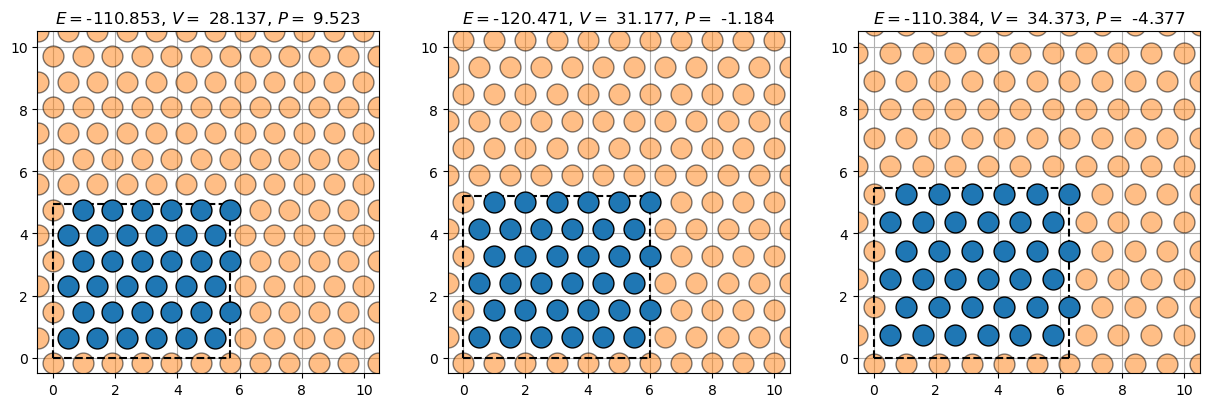

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

unit_cell = (np.array([2.0, 0.0]), np.cos(np.pi/6.0)*np.array([0.0,2.0]))
atom_poses = [np.array([0.0,0.0]), np.array([0.5,0.5]), np.array([1.0,0.0]), np.array([1.5,0.5])]
atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=30) for pos in atom_poses], unit_cell=unit_cell, pbc=True)
atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler)
optimizer = Line_searcher(atom_col=atom_col)
pos_opt, f = optimizer.run(fmax=0.05)
opt_col = create_atom_col_copies(atom_col=atom_col, positions=pos_opt, velocities=np.zeros(shape=pos_opt.shape))[0]
l1, l2 = unit_cell
new_poses = []
for i in [0.0, 1.0, 2.0]:
    for j in [0.0, 1.0, 2.0]:
        disp_pos = pos_opt + l1*i + l2*j
        new_poses.append(disp_pos)

unit_cell = (np.array([6.0, 0.0]), 3*np.cos(np.pi/6.0)*np.array([0.0,2.0]))
scaling_factors = [-0.05, 0.0, 0.05]
scaled_cols = []
for ax, scaling_factor in zip(axs, scaling_factors):
    ax.set_xlim([-0.5,10.5])
    ax.set_ylim([-0.5,10.5])
    ax.grid()
    ax.set_aspect("equal")
    atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=20) for pos in np.array(new_poses).reshape(6**2, 2)], unit_cell=unit_cell, pbc=True)
    atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler)
    atom_col.scale_volume(scale_x=scaling_factor, scale_y=scaling_factor)
    vol = atom_col.volume
    p = atom_col.get_pressure(step_size=1e-4)
    ax.set_title(rf"$E = ${atom_col.get_potential_energy().round(3)}, $V = $ {vol.round(3)}, $P = $ {p.round(3)}")
    atom_col.plot_cells(ax=ax, size=15)
    atom_col.reset_plot_axes()
    scaled_cols.append(atom_col)

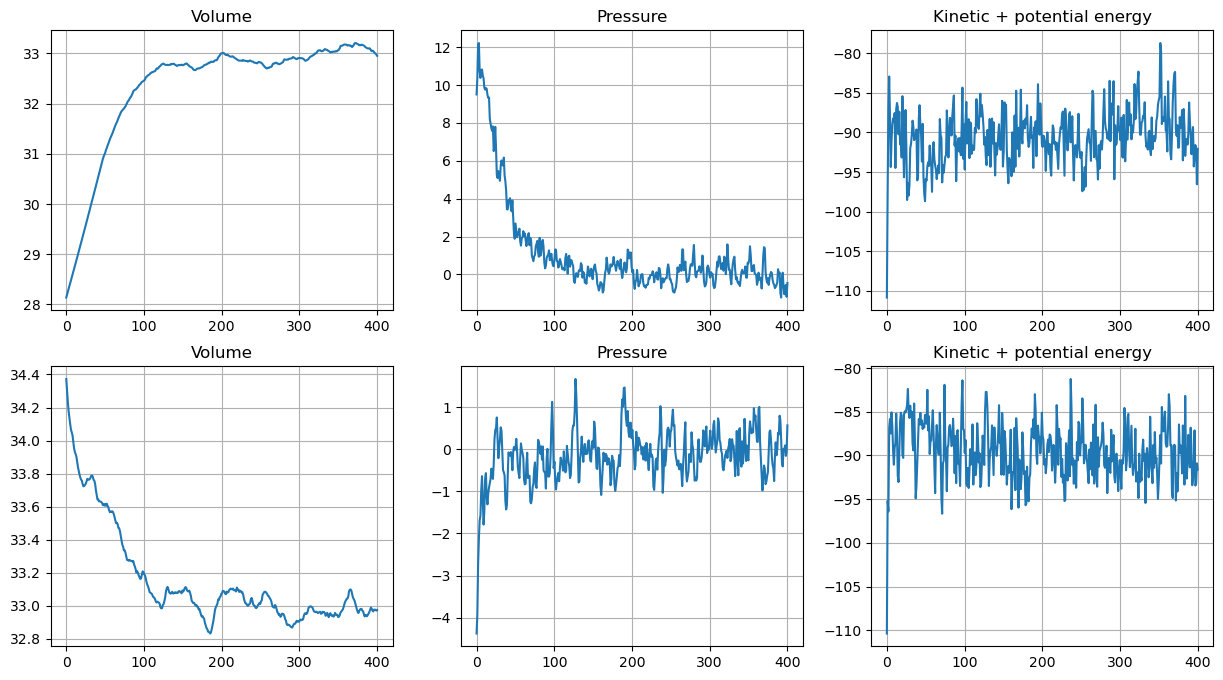

In [16]:
fig, axs = plt.subplots(2,3, figsize=(15,8))

for ax in axs.flatten():
    ax.grid()

for i, scaled_col in enumerate([scaled_cols[0], scaled_cols[2]]):
    md_simulator = MD_sim(atom_col=scaled_col, temp=0.40, time_step=0.001, step_size=1e-3, gamma=1e-5)
    Es, poses, vels, stresses, vols = md_simulator.run_MD_simulation(N_steps=400, reset_unit_cell=False)
    pressures_tot = []
    volumes_tot = []
    energies_tot = []
    for j in range(len(stresses)):
        volumes = []
        pressures = []
        energies = []
        for stress, vol, E in zip(stresses[j], vols[j], Es[j]):
            energies.append(E)
            volumes.append(vol)
            pressures.append(np.mean(stress.diagonal())/vol)
        volumes_tot.append(np.mean(volumes))
        pressures_tot.append(np.mean(pressures))
        energies_tot.append(np.mean(energies))
    xs = np.linspace(0.0, len(energies_tot),len(energies_tot))
    axs[i][0].set_title("Volume")
    axs[i][1].set_title("Pressure")
    axs[i][2].set_title("Kinetic + potential energy")
    axs[i][0].plot(xs, volumes_tot)
    axs[i][1].plot(xs, pressures_tot)
    axs[i][2].plot(xs, energies_tot)

In [4]:
atomlist = [Atom(position=pos) for pos in poses[-1][-1]]
p0_col = Atom_Collection(atomlist=atomlist, unit_cell=(md_simulator.pbc_handler.v1*1.0, md_simulator.pbc_handler.v2*1.0), pbc=True)
p0_col.calculator = LennardJones(eps0=1.0, pbc_handler=md_simulator.pbc_handler, pbc=True)

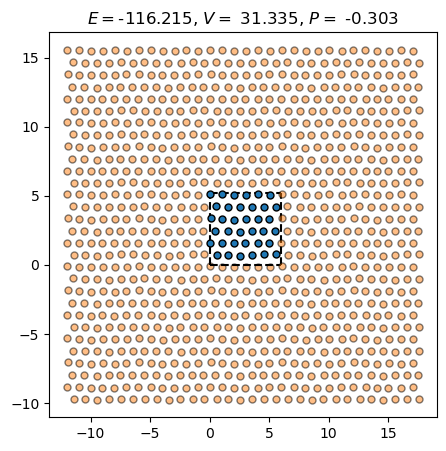

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
p = p0_col.get_pressure(step_size=1e-4)
ax.set_title(rf"$E = ${p0_col.get_potential_energy().round(3)}, $V = $ {vol.round(3)}, $P = $ {p.round(3)}")
p0_col.plot_cells(ax=ax, size=5)
p0_col.reset_plot_axes()

In [6]:
temps = [0.40,0.45,0.50,0.55,0.60]
vols_total = []
pressures_total = []
energies_total = []
md_simulator = MD_sim(atom_col=p0_col, temp=0.15, time_step=0.001, step_size=1e-3, gamma=1e-5)
for temp in temps:
    md_simulator.temp=temp
    Es, poses, vels, stresses, vols = md_simulator.run_MD_simulation(N_steps=400, reset_unit_cell=False)
    pressures_tot = []
    volumes_tot = []
    energies_tot = []
    for j in range(len(stresses)):
        volumes = []
        pressures = []
        energies = []
        for stress, vol, E in zip(stresses[j], vols[j], Es[j]):
            energies.append(E)
            volumes.append(vol)
            pressures.append(np.mean(stress.diagonal())/vol)
        volumes_tot.append(np.mean(volumes))
        pressures_tot.append(np.mean(pressures))
        energies_tot.append(np.mean(energies))
    vols_total.append(volumes_tot)
    pressures_total.append(pressures_tot)
    energies_total.append(energies_tot)

c:\Users\karst\Computational-Physics\Week7\..\classes\calculators\lennardjones.py:12: RuntimeWarning: overflow encountered in power
  t2 = 12.0*(self.sigma**12)/(r**13)


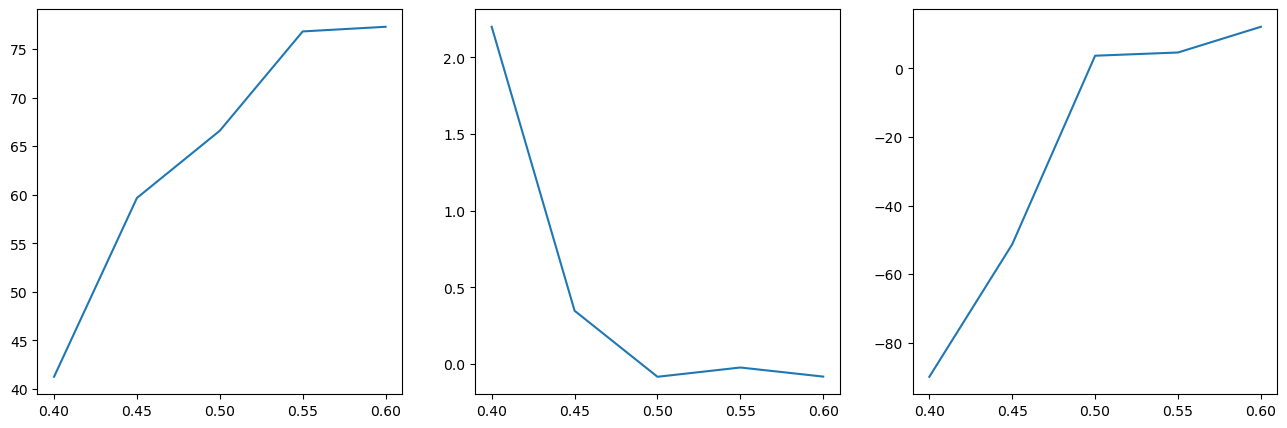

In [7]:
fig, axs = plt.subplots(1,3, figsize=(16,5))
for ax, type in zip(axs, [vols_total, pressures_total, energies_total]):
    mean_vals = []
    for vals in type:
        mean = np.mean(vals[-int(400/2)])
        mean_vals.append(mean)
    ax.plot(temps, mean_vals)    

In [12]:
print(pressures_total[0])

[-0.5246845056351033, -0.2494161540043169, 0.8525251323598401, 0.9465694193148283, 0.9762863835186802, 1.6727002937337108, 1.5953779217754027, 1.93690934283888, 1.657302515277158, 1.213611534625066, 1.4163757958302639, 1.752497775048811, 2.475675599559026, 2.922860218775458, 3.1477915363923303, 2.668235374377898, 1.8072611799587122, 2.190235567078014, 2.9255021351622217, 3.7317093467323095, 3.332356442584209, 2.4308335498334634, 2.494493570844713, 2.10130145608621, 2.468199351875863, 2.2944589709347833, 2.5948658783958365, 2.946612458821252, 2.865642802202075, 2.55376909354461, 2.1674653957301873, 2.491707136090086, 3.120605848085767, 2.9372167336606743, 2.3922417933487536, 2.7625392724551285, 2.6840588037749984, 2.364818709179436, 2.412279258625975, 1.7647693361187793, 1.2899731304264868, 1.254181073976979, 1.1613868055199352, 1.5290817434195372, 1.4852155636496298, 1.6509326904421342, 1.690644149566474, 2.062329016428512, 2.1541995955655624, 2.010631928545023, 1.7013381020590428, 2.4

In [ ]:
fig, ax = plt.subplots()
ax.plot(temps, np.mean(vols_total, axis=1))

In [ ]:
fig, ax = plt.subplots()
i=0
ax.plot(np.linspace(0, len(vols_total[i]), len(vols_total[i])), vols_total[i])
ax.hlines(np.mean(vols_total[i]), 0, len(vols_total[i]))

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim([-1.0,7.0])
ax.set_ylim([-1.0,7.0])
atomlist = [Atom(position=pos, size=20) for pos in positons_total[4][-1]]
p0_col = Atom_Collection(atomlist=atomlist)
p0_col.calculator = LennardJones(eps0=1.0)
s = p0_col.plot(ax=ax)